# Sentiment Analysis mit traditionellen Machine Learning Modellen

Im Folgenden nutzen wir traditionelle Modelle zur Klassifizierung von Sentiments.  
  
Dafür haben wir mit diversen Machine Learning Algorithmen experimentiert.
Die drei besten Algorithmen betrachten wir genauer:   
- Multinomial Naive Bayes
- Logistische Regression
- Linear Support Vector Machines
  
Desweiteren haben wir die Features auf zwei unterschiedliche Arten erstellt und diese Ansätze ebenfalls miteinander verglichen:
- Bag-of-Words (BoW)
- Term Frequency Inverse Document Frequency (TFIDF)

Sowohl BoW als auch TFIDF haben wir mit verschiedenen N-Grams angewandt, um die Ergebnisse miteinander zu vergleichen.  
Dafür haben wir Unigrams, Bigrams sowie Trigrams verwendet.
  
Dieses Vorgehen haben wir auf zwei unterschiedlichen Datensätzen angewandt:   
- Movie Revies: kleineres Datenset, enthält 3 Klassen (-1: negativ, 0: neutral, 1: positiv)  
- Twetts: größeres Datenset, enthält 2 Klassen (-1: negativ, 1: positiv)  

Abschließend haben wir die Accuracys in Tabellen miteinander verglichen und unsere Ergebnisse ausgewertet und interpretiert.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1iBSu5iMtGl5Ys7feuwPxbrIUCugIipJf/LSC_Sentiment_Analysis


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import csv
from evaluation import test_statistics
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%cd Documents/LSC/LSC_Sentiment_Analysis/

[Errno 2] No such file or directory: 'Documents/LSC/LSC_Sentiment_Analysis/'
/content/drive/.shortcut-targets-by-id/1iBSu5iMtGl5Ys7feuwPxbrIUCugIipJf/LSC_Sentiment_Analysis


## Movie Reviews (kleineres Datenset)
- 8088 Samples (nach Balancing)
- 3 Klassen: -1: negativ, 0: neutral, 1: positiv

## 1. Data Loading

Wir laden den Datensatz, den wir zuvor im Notebook "ExploratoryDataAnalysis" aufbereitet und balanciert haben.


In [ ]:
train_set = pd.read_csv ("./data/dataset_mr/Trainset_complete.csv", sep = ';')
test_set = pd.read_csv ("./data/dataset_mr/Testset.csv", sep = ';')

In [ ]:
# balancierte Daten
train_set.Sentiment.value_counts()

-1    2696
 0    2696
 1    2696
Name: Sentiment, dtype: int64

## 2. Data Cleaning

Die Daten haben wir durch folgendes Vorgehen bereinigt:
- alle Zeichen, die keine Buchstaben sind, rausgelöscht. Für die Sentinemt Analyse spielen nur Wörter eine Rolle. Ziffern oder Sonderzeichen liefern keinen großen Mehrwert.
- alle Buchstaben auf Kleinschreibung angepasst. So wird z.B: "Amazing" und "amazing" nicht als zwei unterschiedliche Wörter gezählt.
- Stop-Words herausgelöscht. Wir gehen davon aus, dass das bloße Vorhandensein von  Wörtern wie 'and' 'or' 'a' 'she' usw. keinen großen Mehrwert für die Sentimentanalyse liefert
Wir haben die vordefinierten Stop-Words von Natural Language Toolkit (nltk) verwendet, welches 179 Wörter enthält, die sehr häufig in der englischen Sprache vorkommen.
- Stemming: Wortendungen abgeschnitten, sodass nur der Wortstamm übrig bleibt. Hierzu verwenden wir den Porter-Stemmer-Algorithmus.

Anschließend wenden wir die definierten Funktionen sowohl auf unser Trainings- als auch auf unser Testset an.

In [ ]:
# Nur Buchstaben behalten. Alle anderen Zeichen rauslöschen
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text

# alle Buchstaben auf Kleinschreibung ändern
def convert_to_lowercase(text):
    return text.lower()

def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')
print(len(english_stop_words))
print (english_stop_words[:20])

# Stop Words entfernen
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming mit Porter-Stemmer-Algorithmus
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed


train_set['Phrase'] = train_set['Phrase'].apply(clean_reviews)
test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

train_set['Phrase'] = train_set['Phrase'].apply(remove_stop_words)
test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

train_set['Phrase'] = train_set['Phrase'].apply(text_stemming)
test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


## 3. Text Vectorization
In diesem Schritt wandeln wir unsere Daten in numerische Form um und erstellen so unsere Features.
Dabei werden die Reviews in eine Matrix aus token counts umgewandelt.  
Der Vektorizer wird dabei an die Trainingsdaten angepasst. Die Anzahl der Features entspricht somit der Anzahl der Token, die im Trainings-Set enthalten sind.  
Dieses Vokabular verwenden wir anschließend ebenfalls zur Transformation des Test-Sets.  
Token, die nur im Test-Set auftauchen, werden von dem Modell also nicht berücksichtigt. Die Test-Daten sollen zunächst für das Modell verborgen bleiben.   
Zudem kann ein Token, das nicht in den Trainingsdaten enthalten ist, nicht gelernt werden und liefert somit keinen Mehrwert für die Vorhersage.   

Wir erstellen die Features auf zwei verschiedene Arten um sie nachher bzgl. ihrer Accuracy zu vergleichen:  
- Bag-of-Words (BoW) -> Dafür nutzen wir den CountVectorizer mit dem Parameter binary=False, sodass die Häufigkeit der Token berücksichtigt wird und nicht nur das Vorhandensein (1:ja, 0:nein)  
- Term Frequency Inverse Document Frequency (TFIDF) -> dafür nutzen wir den TfidfVectorizer mit dem Parameter use_idf=True, sodass die inverse document frequency berücksichtigt wird

Beim BoW Ansatz werden ausschließlich das Vokabluar von Wörtern, sowie die Häufigkeit eines Wortes pro Dokument berücksichtigt -> term frequency.

Bei der Bestimmung von TFIDF Features berücksichtigen wir neben der term-frequency zusätzlich die inverse document frequency.
Diese untersucht das Vorhandensein eines Tokens in allen Dokumenten.  
Ein Token, das in wenigen Dokumenten vorkommt, bekommt einen höheren IDF-Wert.  
Ein Token, das in den meisten Dokumenten vorkommt, erhält dagegen einen geringeren IDF-Wert.  
So können seltene Wörter hervorgehoben werden und häufige Wörter bekommen ein Penalty.  
Der TF-IDF errechnet sich anschließend als Produkt aus der term-frequency und der inverse document frequency.


### N-Grams
Mit N-Grams können wir vorgeben, ob der Bag-of-Words bzw. TGIDF Algorithmus nur einzelne Wörter oder auch aufeinanderfolgende Wörter berücksichtigt
- Unigram: Alle eindeutigen Wörter in einem Dokument
- BiGram: Alle Permutationen von zwei aufeinanderfolgenden Wörtern in einem Dokument
- TriGram: Alle Permutationen von drei aufeinanderfolgenden Wörtern in einem Dokument

Nach Vextorization:  
Jeder Token im Vokabular wird durch eine Spalte im Datensatz repräsentiert.
Für jedes Review im Datensatz wird die Frequency der Token (term-frequency) dargestellt.

In [ ]:
# Text Datne in numerische Daten umwandeln

# Argument binary=False: Vocabel-Vector mit term-frequency füllen
# binary = True: Vocabel-Vector mit Vorhandensein der Token füllen (1 vorhanden, 0 nicht vorhanden)
# ngram _range = Unigram: (1,1); Bigram: (1,2); Trigram: (1,3)

# Vectorizer für Bag-of-Word
# Unigram
vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
# Bigram
vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
# Trigram
vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))

In [ ]:
# Vectorizer für TGIDF
# Unigram
vectorizer_uni_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
# Bigram
vectorizer_bi_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
# Trigram
vectorizer_tri_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,3))

In [ ]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - BoW

uni_train_bow = vectorizer_uni_bow.fit_transform(train_set['Phrase'])
uni_test_bow = vectorizer_uni_bow.transform(test_set['Phrase'])

bi_train_bow = vectorizer_bi_bow.fit_transform(train_set['Phrase'])
bi_test_bow = vectorizer_bi_bow.transform(test_set['Phrase'])

tri_train_bow = vectorizer_tri_bow.fit_transform(train_set['Phrase'])
tri_test_bow = vectorizer_tri_bow.transform(test_set['Phrase'])

In [ ]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - TGIDF

uni_train_tfidf = vectorizer_uni_tfidf.fit_transform(train_set['Phrase'])
uni_test_tfidf = vectorizer_uni_tfidf.transform(test_set['Phrase'])

bi_train_tfidf = vectorizer_bi_tfidf.fit_transform(train_set['Phrase'])
bi_test_tfidf = vectorizer_bi_tfidf.transform(test_set['Phrase'])

tri_train_tfidf = vectorizer_tri_tfidf.fit_transform(train_set['Phrase'])
tri_test_tfidf = vectorizer_tri_tfidf.transform(test_set['Phrase'])

In [ ]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']

## 4. Klassifizierungsmodelle trainieren

Zunächst trainieren wir diverse Klassifikations-Algorithmen, die wir anhand ihrer Accuracy miteinander vergleichen.  
Im ersten Schritt trainieren wir nur mit den Unigram Bag-of-Words Features, um einen ersten Eindruck zu bekommen, welche Modelle sich am besten für unsere Sentiment Analyse eignen.  
Die folgenden drei Modelle erreichten dabei die beste Accuracy:

- Naive Bayes  
- Logistische Regression  
- Linear Support Vector Machines (LSVM)

Diese wollen wir im weiteren Verlauf genauer betrachten.
Dafür geben wir nacheinander die Unigrams, Bigrams und Trigrams in die Modelle, sodass wir die Accuracy vergleichen können.  
Dieses Vorgehen machen wir erst mit den BoW Features und anschließend mit TFIDF Features. Am Ende vergleichen wir alle Accuracys miteinander, um den besten Ansatz zu finden

### 4.1. Vergleich diverser Modelle

Vergleich diverser klassischer Klassifikationsalgorithmen:
- Logistische Regression
- K-Nearest-Neighbors
- Random Forest
- Linear Support Vector Machines
- Nearest Centroid
- Mutinomial Naive Bayes

In [ ]:
from sklearn import metrics
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(tri_train_tfidf, train_labels)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(tri_test_tfidf)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(test_labels, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [ ]:
# diverse Modelle testen, die 3 mit bester Accuracy verfolgen wir weiter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    (NearestCentroid(), "NearestCentroid"),
    (MultinomialNB(), "Multinomial naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 10.7s
test time:  0.00436s
accuracy:   0.532
dimensionality: 109529
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.003s
test time:  1.41s
accuracy:   0.489

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 2.14e+02s
test time:  0.23s
accuracy:   0.485

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train time: 0.605s
test time:  0.00196s
accuracy:   0.532
dimensionality: 109529
density: 1.0


NearestCentroid
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.0143s


### 4.2.  Naive Bayes

Der Naive Bayes Klassifizierer sagt das Label einer neuen Beobachtung voraus, indem er die Wahrscheinlichkeiten für alle möglichen Zustände dieser Variablen berechnet und den Zustand mit der höchsten Wahrscheinlichkeit vorhersagt. In diesem Fall gibt es drei mögliche Zustände: positive, neutrale oder negative Bewertung.  
  
Zunächst wird für die drei Zustände der Prior berechnet: Die Wahrscheinlichkeit für das Auftreten des Zustandes an sich  
-> z.B. die Wahrscheinlichkeit, dass es sich um einen negativen Review handelt.   
Da wir mit balancierten Daten arbeiten, ist der Prior für jede der drei Klassen: 0,33333
  
Anschließend werden die bedingten Wahrscheinlichkeiten (Conditional Likelihoods) berechnet:  
Wahrscheinlichkeit, dass Wort n vorkommt, unter der Bedingung, dass es z.B. eine positive Bewertung ist.  
Die Conditional Likelihoods für jedes Wort in der Bewertung werden miteinander sowie mit dem jeweiligen Prior der Klasse multipliziert.  
Diese Berechnung wird für jede mögliche Klasse durchgeführt.  
Anschließend wird die Klasse mit der höchsten Wahrscheinlichkeit angenommen.  

Beim MultinomialNB von sklearn kann über den Parameter "fit_prior" angegeben werden, ob der Prior einer Klasse für die Berechnung einbezogen werden soll.
Sein default-Wert ist true. Da wir mit balancierten Daten arbeiten, macht es in unserem Fall keinen Unterschied, ob wir diesen Parameter auf TRUE oder FALSE setzen.  
Desweiteren ist es möglich über den Parameter "class_prior" die Priors für die Klassen vorzugeben und dadurch die Wahrscheinlichkeiten zu beeinflussen.
Wir haben mit diversen Einstellungen dieses Parameters experimentiert. Wenn wir den Prior für "neutral" auf 0.5 hochsetzen und die Prior für "negativ" und "positiv" auf 2.5, dann kann der Algorithmus neutrale Reviews deutlich besser erkennen.  
Dafür werden die Predictions der tatsächlich positiven oder tatsächlich negativen Reviews schlechter, sodass die Accuracy gleich bleibt.  

Vorteile:
- Naive Bayes benötigt keine kontinuierlichen Werte, wir könnten auch mit den Labels "negativ", "neutral", "positiv" trainieren  
(da wir das Preprocessing einheitlich für alle Modelle vorgenommen haben, arbeiten wir mit kontinuierlichen Werten)
- Algorithmus ist sehr einfach und schnell zu trainieren
  
Nachteile:
- Nur Labels funktionieren als Input, was für uns aber kein Problem dartellt, da wir ohnehin Labels als Input haben
- Naive Annahme:  
Dem Naive Bayes Klassifizierer liegt die Annahme zugrunde, dass es keine Abhängigkeiten zwischen den Features gibt.  
Diese Annahme wird in der Praxis fast immer verletzt, so wie auch in diesem Fall. Bestimmte Wörter werden häufiger zusammen benutzt.  
Kommt zum Beipiel das Word "lustig" in einem Satz vor, ist es wahrscheinlicher, dass auch das Wort "lachen" darin vorkommt.  
  
Trotzdem liefert der Naive Bayes Klassifizierer interessante Informationen.

#### 4.2.1. Naive Bayes: Unigram
Wir wenden den Naive Bayes Klassifierer auf unsere bereits definierten Unigram Features an

##### 4.2.1.1 Bag-of-Words

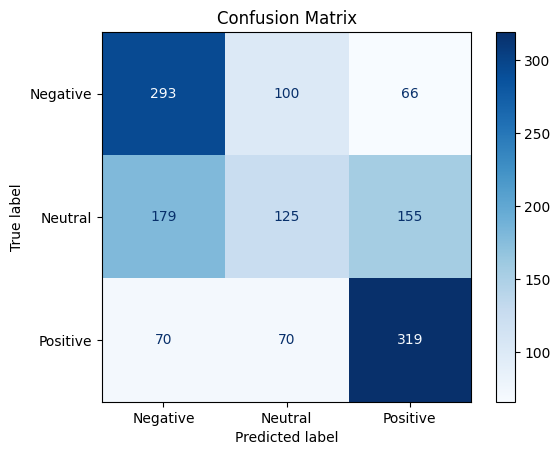

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.64      0.59       459
     Neutral       0.42      0.27      0.33       459
    Positive       0.59      0.69      0.64       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [ ]:
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_bow, train_labels)

predictions = uni_nb.predict(uni_test_bow)

mr_nb_uni_bow = test_statistics(predictions, test_labels)

##### 4.2.1.1 Bag-of-Words mit Parameter class_prior um neutrale Reviews besser zu erkennen
Durch den Parameter "class_prior" können wir den Prior für die Klassen vorgeben.
Dadurch können wir das Problem angehen, dass neutrale Reviews schlecht erkannt werden, indem wir die Prior-Wahrscheinlichkeit für die Klasse "neutral" höher angeben als den Prior für die anderen beiden Klasse "negativ" und "positiv".

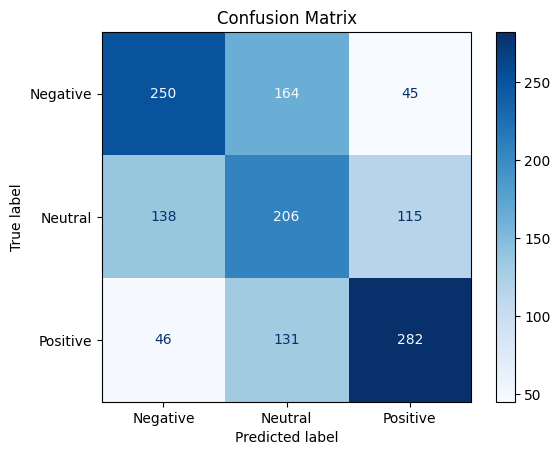

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.58      0.54      0.56       459
     Neutral       0.41      0.45      0.43       459
    Positive       0.64      0.61      0.63       459

    accuracy                           0.54      1377
   macro avg       0.54      0.54      0.54      1377
weighted avg       0.54      0.54      0.54      1377



In [ ]:
uni_nb = MultinomialNB(class_prior = [0.25, 0.5, 0.25])
uni_nb.fit(uni_train_bow, train_labels)

predictions = uni_nb.predict(uni_test_bow)
test_statistics(predictions, test_labels)

##### 4.2.1.2 TFIDF

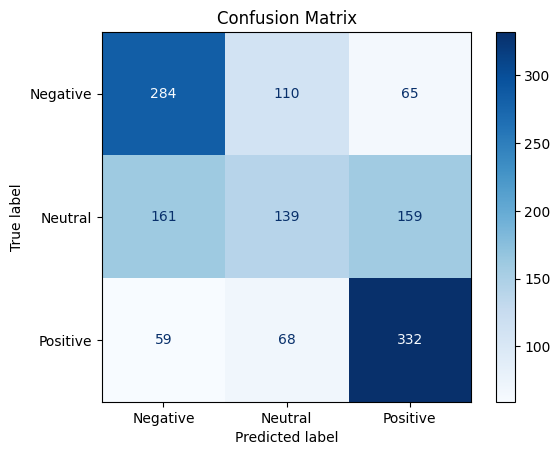

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.56      0.62      0.59       459
     Neutral       0.44      0.30      0.36       459
    Positive       0.60      0.72      0.65       459

    accuracy                           0.55      1377
   macro avg       0.53      0.55      0.53      1377
weighted avg       0.53      0.55      0.53      1377



In [ ]:
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_tfidf, train_labels)

predictions = uni_nb.predict(uni_test_tfidf)

mr_nb_uni_tf = test_statistics(predictions, test_labels)

#### 4.2.2 Naive Bayes: Bigram

##### 4.2.2.1 Bag-of-Words

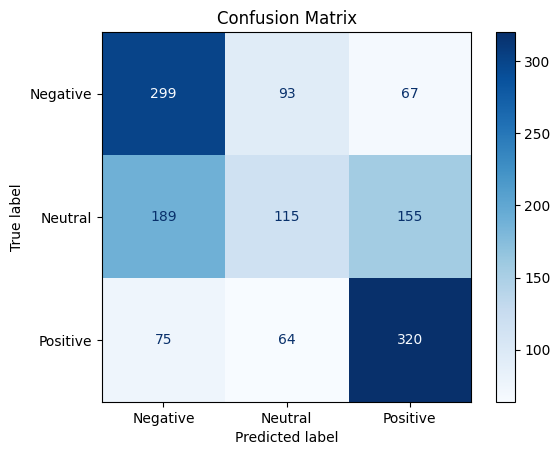

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.65      0.59       459
     Neutral       0.42      0.25      0.31       459
    Positive       0.59      0.70      0.64       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



In [ ]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_bow, train_labels)

predictions = bi_nb.predict(bi_test_bow)
mr_nb_bi_bow = test_statistics(predictions, test_labels)


##### 4.2.2.2 TFIDF

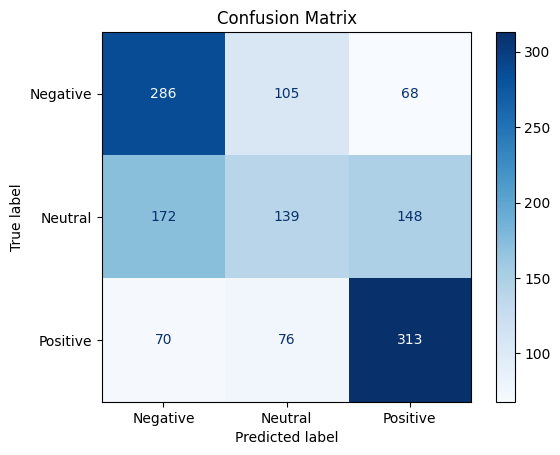

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.62      0.58       459
     Neutral       0.43      0.30      0.36       459
    Positive       0.59      0.68      0.63       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [ ]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_tfidf, train_labels)

predictions = bi_nb.predict(bi_test_tfidf)
mr_nb_bi_tf = test_statistics(predictions, test_labels)

#### 4.2.3 Naive Bayes: Trigram

##### 4.2.3.1 Bag-of-Words

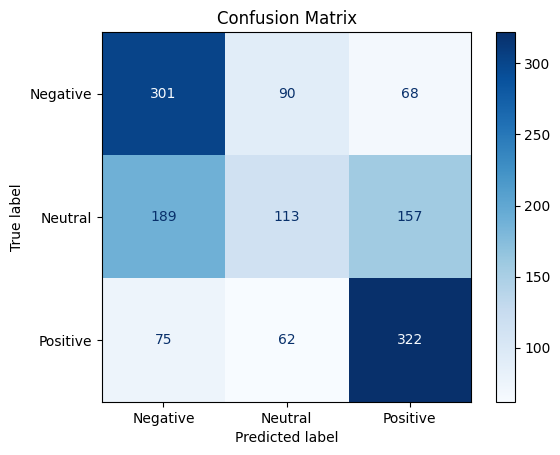

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.66      0.59       459
     Neutral       0.43      0.25      0.31       459
    Positive       0.59      0.70      0.64       459

    accuracy                           0.53      1377
   macro avg       0.52      0.53      0.51      1377
weighted avg       0.52      0.53      0.51      1377



In [ ]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_bow, train_labels)

predictions = tri_nb.predict(tri_test_bow)
mr_nb_tri_bow = test_statistics(predictions, test_labels)


##### 4.2.3.2 TFIDF

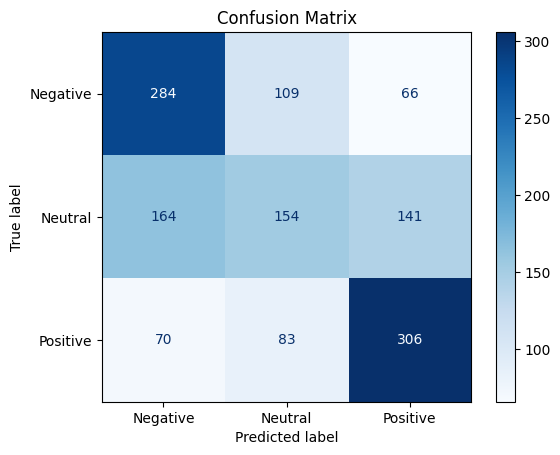

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.62      0.58       459
     Neutral       0.45      0.34      0.38       459
    Positive       0.60      0.67      0.63       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.53      1377
weighted avg       0.53      0.54      0.53      1377



In [ ]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_tfidf, train_labels)

predictions = tri_nb.predict(tri_test_tfidf)
mr_nb_tri_tf = test_statistics(predictions, test_labels)

### 4.3 Logistische Regression



#### 4.3.1. Log Regression: Unigram

##### 4.3.1.1 Bag-of-Words

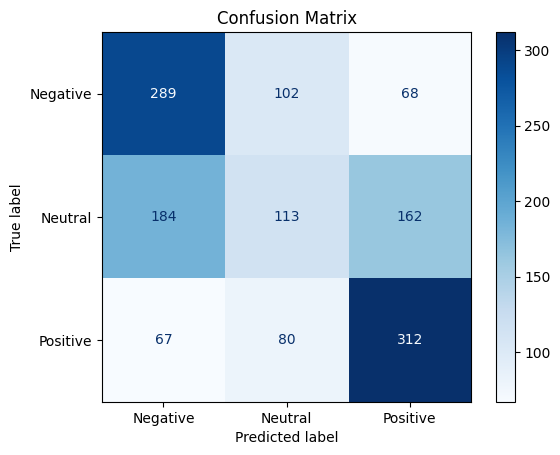

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.63      0.58       459
     Neutral       0.38      0.25      0.30       459
    Positive       0.58      0.68      0.62       459

    accuracy                           0.52      1377
   macro avg       0.50      0.52      0.50      1377
weighted avg       0.50      0.52      0.50      1377



In [ ]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_bow, train_labels)

predictions = uni_logreg.predict(uni_test_bow)
mr_lr_uni_bow = test_statistics(predictions, test_labels)

##### 4.3.1.2 TFIDF

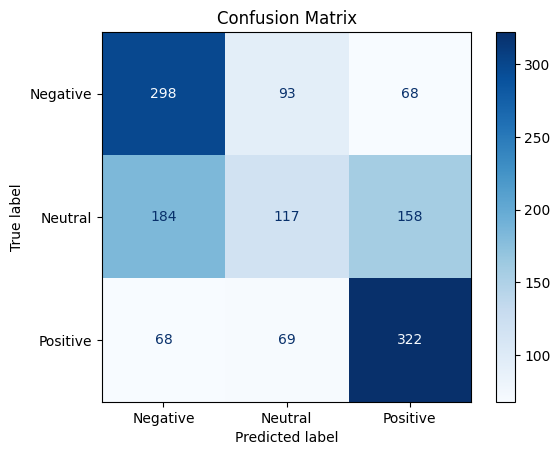

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.65      0.59       459
     Neutral       0.42      0.25      0.32       459
    Positive       0.59      0.70      0.64       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [ ]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_tfidf, train_labels)

predictions = uni_logreg.predict(uni_test_tfidf)
mr_lr_uni_tf = test_statistics(predictions, test_labels)

#### 4.3.2. Log Regression: Bigram

##### 4.3.2.1 Bag-of-Words

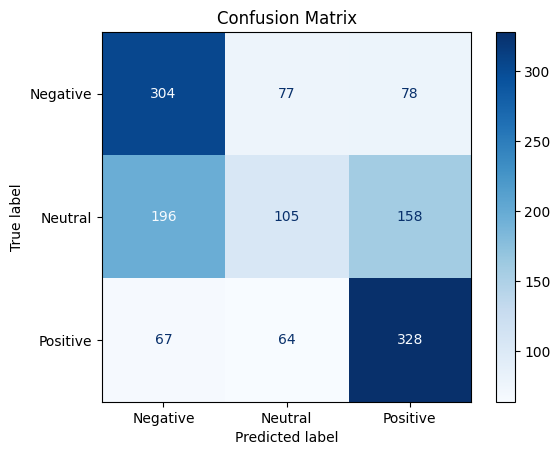

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.66      0.59       459
     Neutral       0.43      0.23      0.30       459
    Positive       0.58      0.71      0.64       459

    accuracy                           0.54      1377
   macro avg       0.51      0.54      0.51      1377
weighted avg       0.51      0.54      0.51      1377



In [ ]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_bow, train_labels)

predictions = bi_logreg.predict(bi_test_bow)
mr_lr_bi_bow = test_statistics(predictions, test_labels)
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt

##### 4.3.2.2 TFIDF

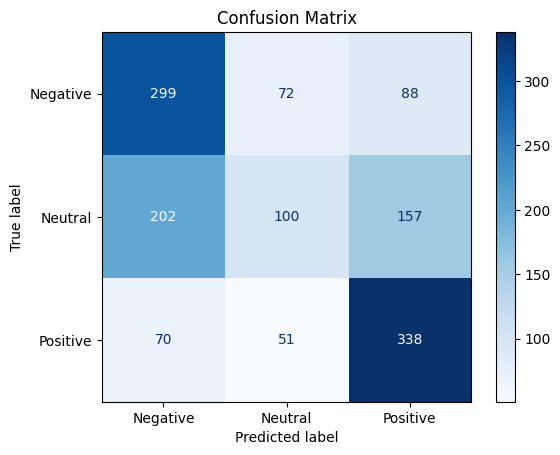

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.52      0.65      0.58       459
     Neutral       0.45      0.22      0.29       459
    Positive       0.58      0.74      0.65       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.51      1377
weighted avg       0.52      0.54      0.51      1377



In [ ]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_tfidf, train_labels)

predictions = bi_logreg.predict(bi_test_tfidf)
mr_lr_bi_tf = test_statistics(predictions, test_labels)

#### 4.3.3. Log Regression: Trigram

##### 4.3.3.1 Bag-of-Words

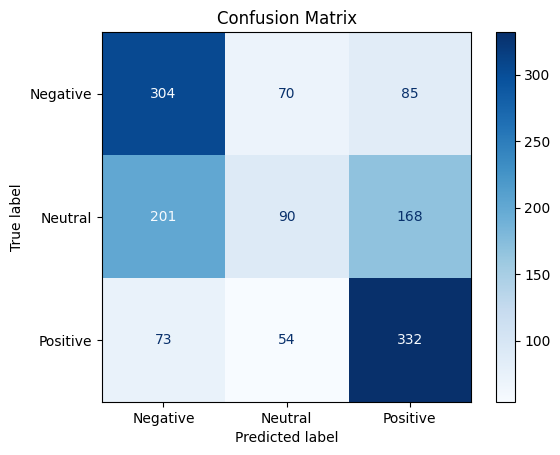

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.66      0.59       459
     Neutral       0.42      0.20      0.27       459
    Positive       0.57      0.72      0.64       459

    accuracy                           0.53      1377
   macro avg       0.50      0.53      0.50      1377
weighted avg       0.50      0.53      0.50      1377



In [ ]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_bow, train_labels)

predictions = tri_logreg.predict(tri_test_bow)
mr_lr_tri_bow = test_statistics(predictions, test_labels)

##### 4.3.3.2 TFIDF

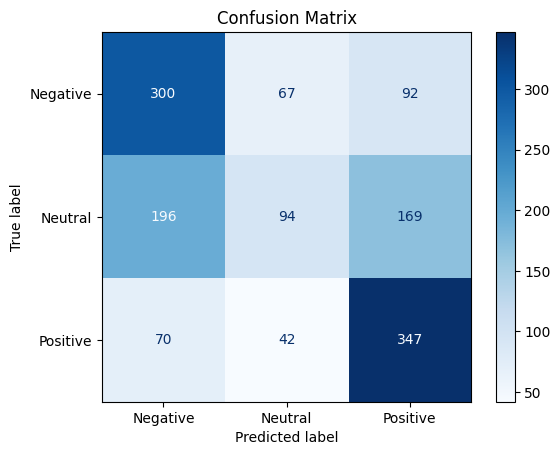

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.65      0.59       459
     Neutral       0.46      0.20      0.28       459
    Positive       0.57      0.76      0.65       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.51      1377
weighted avg       0.52      0.54      0.51      1377



In [ ]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_tfidf, train_labels)

predictions = tri_logreg.predict(tri_test_tfidf)
mr_lr_tri_tf = test_statistics(predictions, test_labels)

### 4.4 Linear Support Vector Machine (LSVM)

Support Vektor Maschinen teilen die Klassen mithilte von Trennungsebenen ein. Dabei werden die Ebenen so gewählt, dass zwischen den Klassen ein möglichst großer Bereich bleibt, der frei von Samples ist.  

Wir haben uns für den LinearSVC Klassifizierer entschieden, da dieser deutlich weniger Zeit benötigt, als der SVC Klassifizierer und dabei ähnlich gute Ergebnisse liefert.
Die besten Ergebnisse haben wir mit den Parametereinstellungen squared_hinge als Loss-Funktion in Kombination mit der L2-Regularisierung (auch Ridge-Regression) erreicht.
Bei der L2 Regularisierung wird ein Bestrafungswert (=Penalty) auf die Loss-Funktion gerechnet, wenn Gewichte verwendet werden. Dies führt dazu, dass Gewichte nur voll einbezogen werden, wenn ihr Beitrag zur Verringerung des Loss höher ist, als der Bestrafungswert. Im Gegensatz zur L1-Regularisierung (Lasso Regression), nähern sich die Gewichte bei der L2-Regularisierung nur an 0 an, gehen aber nicht gegen 0. Die bessere Performance der L2-Regularisierung im Vergleich zur L1-Regularisierung spricht dafür, dass der Großteil unserer Token wertvolle Prädiktoren sind, die zur Veringerung des Loss beitragen.
Das kann damit zusammenhängen, dass wir zuvor die Stop-Words, die wenig Mehrwert für die Sentimentanalyte liefern, herausgelöscht haben.

Für uns relevante Vorteile bestehen in dem einfachen Training des Modells. Zudem skalieren SVM gut für höherdimensionale Daten.
Ein Nachteil, der für uns problematisch werden kann, ist die Tatsache, dass SVM mehr Samples als Anzahl an Features benötigen um gut zu funktionieren. Dies ist beim Bag-of-Word Ansatz selten der Fall, da jedes Wort (Unigram) bzw. die Kobination von Wörtern (Bi- und Trigrams) ein Feature darstellt und wir somit mehr Features als Samples (also Bewertungen) haben.  

#### 4.4.1. LSVM: Unigram

##### 4.4.1.1 Bag-of-Words

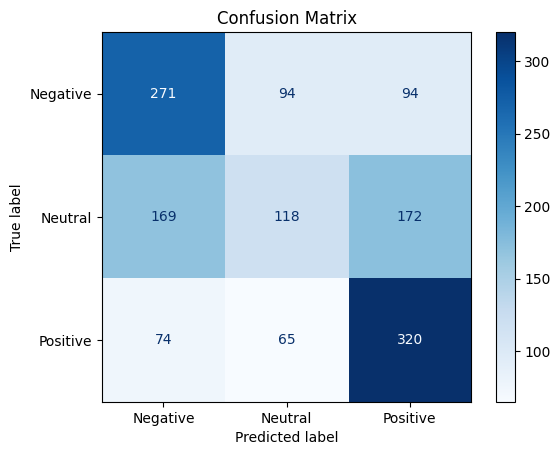

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.59      0.56       459
     Neutral       0.43      0.26      0.32       459
    Positive       0.55      0.70      0.61       459

    accuracy                           0.51      1377
   macro avg       0.50      0.51      0.50      1377
weighted avg       0.50      0.51      0.50      1377



In [ ]:
uni_lsvm = sklearn.svm.LinearSVC(loss = 'squared_hinge', penalty='l2')
uni_lsvm.fit(uni_train_bow, train_labels)

predictions = uni_lsvm.predict(uni_test_bow)
mr_ls_uni_bow = test_statistics(predictions, test_labels)

##### 4.4.1.2 TFIDF

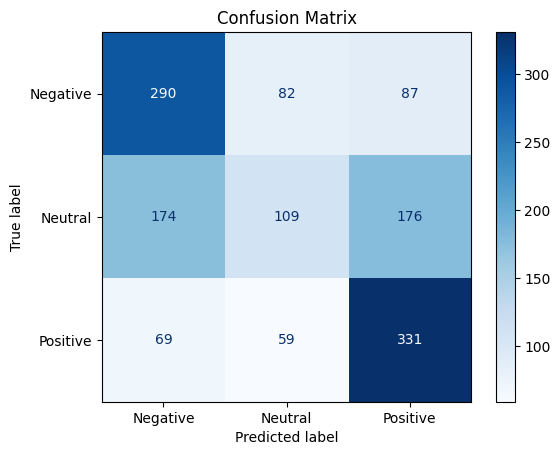

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.63      0.58       459
     Neutral       0.44      0.24      0.31       459
    Positive       0.56      0.72      0.63       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



In [ ]:
uni_lsvm = sklearn.svm.LinearSVC()
uni_lsvm.fit(uni_train_tfidf, train_labels)

predictions = uni_lsvm.predict(uni_test_tfidf)
mr_ls_uni_tf = test_statistics(predictions, test_labels)

#### 4.4.2. LSVM: Bigram

##### 4.4.2.1 Bag-of-Words

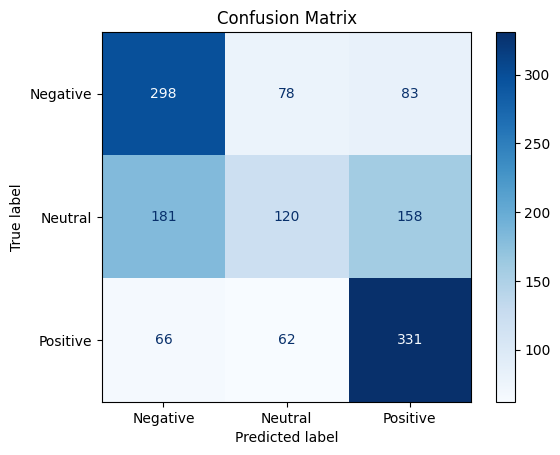

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.65      0.59       459
     Neutral       0.46      0.26      0.33       459
    Positive       0.58      0.72      0.64       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.52      1377
weighted avg       0.53      0.54      0.52      1377



In [ ]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(bi_train_bow, train_labels)

predictions = bi_lsvm.predict(bi_test_bow)
mr_ls_bi_bow = test_statistics(predictions, test_labels)

##### 4.4.2.2 TFIDF

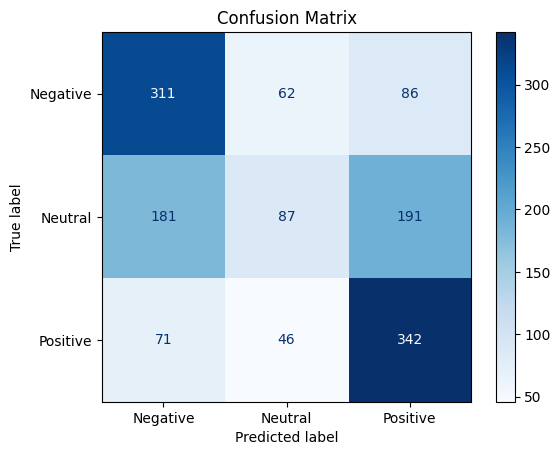

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.68      0.61       459
     Neutral       0.45      0.19      0.27       459
    Positive       0.55      0.75      0.63       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.50      1377
weighted avg       0.52      0.54      0.50      1377



In [ ]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(bi_train_tfidf, train_labels)

predictions = bi_lsvm.predict(bi_test_tfidf)
mr_ls_bi_tf = test_statistics(predictions, test_labels)

#### 4.4.3. LSVM: Trigram

##### 4.4.3.1 Bag-of-Words

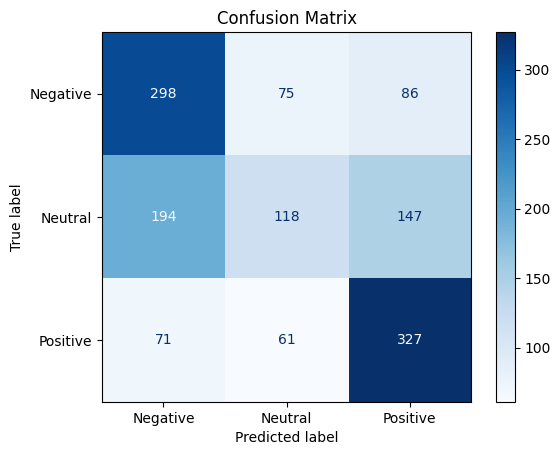

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.65      0.58       459
     Neutral       0.46      0.26      0.33       459
    Positive       0.58      0.71      0.64       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.52      1377
weighted avg       0.53      0.54      0.52      1377



In [ ]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(tri_train_bow, train_labels)

predictions = tri_lsvm.predict(tri_test_bow)
mr_ls_tri_bow = test_statistics(predictions, test_labels)

##### 4.4.3.2 TFIDF

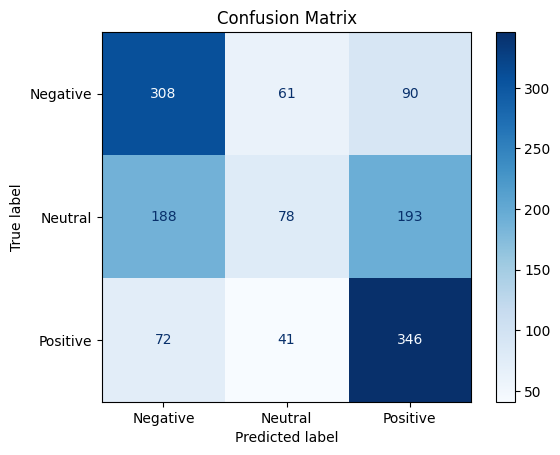

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.67      0.60       459
     Neutral       0.43      0.17      0.24       459
    Positive       0.55      0.75      0.64       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.49      1377
weighted avg       0.51      0.53      0.49      1377



In [ ]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(tri_train_tfidf, train_labels)

predictions = tri_lsvm.predict(tri_test_tfidf)
mr_ls_tri_tf = test_statistics(predictions, test_labels)

## 5. Ergebnisse

In den Confusion Matritzen ist gut zu erkennen, dass die klassischen Algorithmen positive und negative Bewertungen tendenziell voneinander unterscheiden können.  
Große Probleme haben sie jedoch bei den neutralen Bewertungen. Diese werden von den Algorithmen häufiger als positive oder negative Bewertungen klassifiziert.  
Das Label "neutral" wird bei den tatsächlich neutralen Bewertungen am seltensten vergeben.  
Der Naive Bayes Algorithmus auf Trigram TFIDF Daten schafft es immerhin "neutral" als zweithäufigstes Label bei tatsächlich neutralen Bewertungen zu erkennen.
Zudem ist es möglich durch den Parameter "class_prior" den Prior für neutrale Bewertungen hochzusetzen und gleichzeitig den Prior für positive und negative Bewertungen herunterzusetzen. Dadurch können die neutralen Reviews deutlich besser erkannt werden. Da gleichzeitig die positiven und negativen Reviews entsprechend schlechter erkannt werden, verbessert sich die Accuracy nicht sondern wird in manchen Fällen sogar schlechter.
Damit kommen wir nach umfangreichen testen zu dem Ergebnis, dass die klassischen Klassifizierungsalgorithmen einen guten Beitrag zur Unterscheidung zwischen positiven und negativen Sentiments leisten.
Sie funktioneren jedoch auf unseren Daten nicht mehr so gut, wenn eine dritte (neutrale) Klasse vorliegt.

Der Multinomial Naive Bayes Algorithmus erzielt auf unserem Movie-Review Datensatz die besten Ergebnisse.  
Trotz der verletzten Annahme "Unabhängigkeit zwischen den einzelnen Features", funktioniert dieser Algorithmus am besten von den klassischen Modellen.  

Zwischen den N-Grams gibt es dabei nur geringe Unterschiede in der Accuracy.
Die Bi- und Trigrams enthalten mehr Informationen, als das Uni-Gram, daher liefern diese auch erwartungsgemäß eine leicht bessere Accuracy.  
Kommentare wie z.B. "nicht gut" können bei den Bi- und Trigramms ebenfalls erfasst werden, bei den Unigrams würden "nicht" und "gut" einzeln gezählt werden und nicht mehr im direkten Zusammenhang stehen.  
Der Unterschied ist allerdings nur sehr gering.  

Überraschend hingegen ist die Erkenntnis, dass TGIDF auf den Movie-Review Daten keine besseren Ergebnisse liefert als der Bag-of-Words Ansantz.  
Die inverse document frequency scheint bei der Sentiment Analyse keine große Rolle zu spielen.  

### 5.1. Bag-of-Words Ergebnisse

In [ ]:
mr_bow = {'Naive Bayes': [mr_nb_uni_bow, mr_nb_bi_bow, mr_nb_tri_bow], 'Log Regression': [mr_lr_uni_bow, mr_lr_bi_bow, mr_lr_tri_bow], 'LSVM': [mr_ls_uni_bow, mr_ls_bi_bow, mr_ls_tri_bow]}
df_mr_bow = pd.DataFrame((mr_bow), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_bow)

          Naive Bayes  Log Regression      LSVM
Uni-gram     0.535948        0.518519  0.514887
Bi-gram      0.533043        0.535221  0.543936
Tri-gram     0.534495        0.527233  0.539579


### 5.2. TFIDF Ergebnisse

In [ ]:
(mr_tfidf) = {'Naive Bayes': [mr_nb_uni_tf, mr_nb_bi_tf, mr_nb_tri_tf], 'Log Regression': [mr_lr_uni_tf, mr_lr_bi_tf, mr_lr_tri_tf], 'LSVM': [mr_ls_uni_tf, mr_ls_bi_tf, mr_ls_tri_tf]}
df_mr_tfidf = pd.DataFrame((mr_tfidf), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_tfidf)

          Naive Bayes  Log Regression      LSVM
Uni-gram     0.548293        0.535221  0.530138
Bi-gram      0.535948        0.535221  0.537400
Tri-gram     0.540305        0.538126  0.531590


## Tweets (größeres Daten-Set)
- 1,6 mio Samples (nach Balancing)
- 2 Klassen: -1: negativ, 1: positiv
  
Wir haben hier den gleichen Code angewandt, wie bei dem kleineren Datensatz, daher ist unser Vorgehen nicht noch einmal beschrieben

## 1. Data Loading

In [ ]:
train_set = pd.read_csv ("data/dataset_tw/Trainset_complete.csv", sep = ';')
test_set = pd.read_csv ("data/dataset_tw/Testset.csv", sep = ';')

In [ ]:
# Daten um NaNs bereinigen
train_set = train_set.dropna()

# Sicherstellen, dass in "Phrase" nur strings stehen, damit Daten weiterverarbeitet werden können
train_set ['Phrase'] = train_set['Phrase'].astype(str)

## 2. Data Cleaning

In [ ]:
# Für Sentimentanalyse zählen nur Wörter
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text

# Groß- und Kleinschreibung egal
def convert_to_lowercase(text):
    return text.lower()

def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')

# Stop Words removal
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed


train_set['Phrase'] = train_set['Phrase'].apply(clean_reviews)
test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

train_set['Phrase'] = train_set['Phrase'].apply(remove_stop_words)
test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

train_set['Phrase'] = train_set['Phrase'].apply(text_stemming)
test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

## 3. Text Vectorization

In [ ]:
# Vectorizer für Bag-of-Word
# Unigram
vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
# Bigram
vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
# Trigram
vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))


In [ ]:
# Vectorizer für TFIDF
# Unigram
vectorizer_uni_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
# Bigram
vectorizer_bi_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
# Trigram
vectorizer_tri_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,3))

In [ ]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - BoW

uni_train_bow = vectorizer_uni_bow.fit_transform(train_set['Phrase'])
uni_test_bow = vectorizer_uni_bow.transform(test_set['Phrase'])

bi_train_bow = vectorizer_bi_bow.fit_transform(train_set['Phrase'])
bi_test_bow = vectorizer_bi_bow.transform(test_set['Phrase'])

tri_train_bow = vectorizer_tri_bow.fit_transform(train_set['Phrase'])
tri_test_bow = vectorizer_tri_bow.transform(test_set['Phrase'])

In [ ]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - TFIDF

uni_train_tfidf = vectorizer_uni_tfidf.fit_transform(train_set['Phrase'])
uni_test_tfidf = vectorizer_uni_tfidf.transform(test_set['Phrase'])

bi_train_tfidf = vectorizer_bi_tfidf.fit_transform(train_set['Phrase'])
bi_test_tfidf= vectorizer_bi_tfidf.transform(test_set['Phrase'])

tri_train_tfidf = vectorizer_tri_tfidf.fit_transform(train_set['Phrase'])
tri_test_tfidf = vectorizer_tri_tfidf.transform(test_set['Phrase'])

In [ ]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

## 4. Klassifizierungsmodelle trainieren

### 4.1.  Naive Bayes

#### 4.1.1. Naive Bayes: Unigram

##### 4.1.1.1 Bag-of-Words

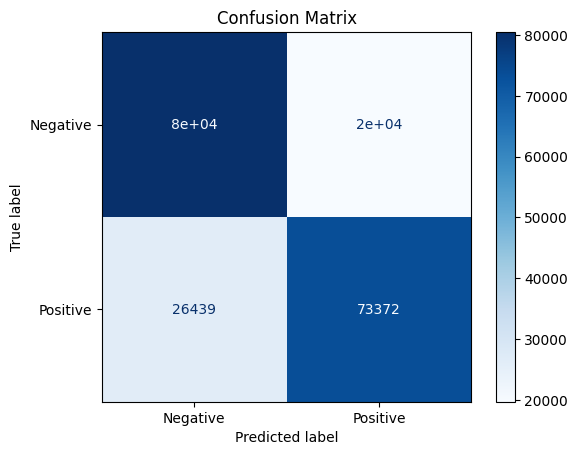

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.75      0.80      0.78    100189
    Positive       0.79      0.74      0.76     99811

    accuracy                           0.77    200000
   macro avg       0.77      0.77      0.77    200000
weighted avg       0.77      0.77      0.77    200000



In [ ]:
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_bow, train_labels)

predictions = uni_nb.predict(uni_test_bow)

tw_nb_uni_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.1.1.2 TFIDF

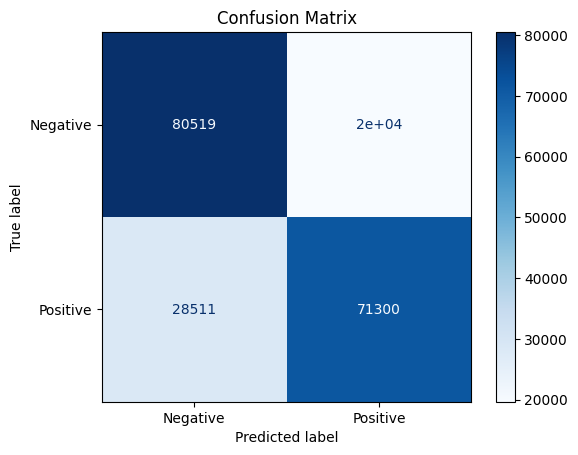

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.74      0.80      0.77    100189
    Positive       0.78      0.71      0.75     99811

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



In [ ]:
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_tfidf, train_labels)

predictions = uni_nb.predict(uni_test_tfidf)

tw_nb_uni_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.1.2. Naive Bayes: Bigram

##### 4.1.2.1 Bag-of-Words

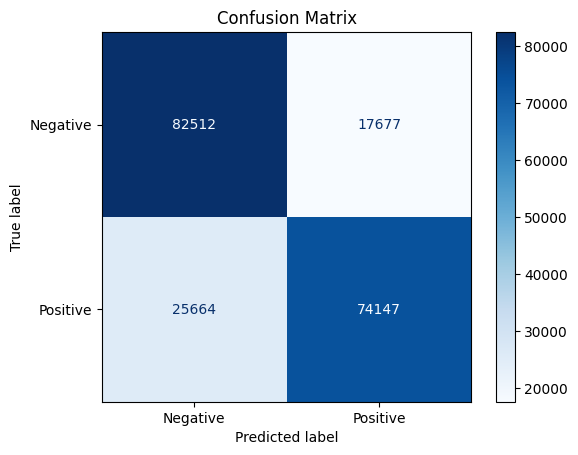

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.76      0.82      0.79    100189
    Positive       0.81      0.74      0.77     99811

    accuracy                           0.78    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.79      0.78      0.78    200000



In [ ]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_bow, train_labels)

predictions = bi_nb.predict(bi_test_bow)
tw_nb_bi_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])


##### 4.1.2.2 TFIDF

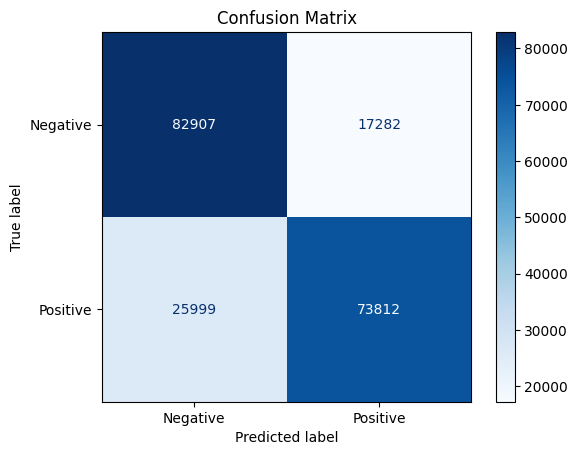

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.76      0.83      0.79    100189
    Positive       0.81      0.74      0.77     99811

    accuracy                           0.78    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.79      0.78      0.78    200000



In [ ]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_tfidf, train_labels)

predictions = bi_nb.predict(bi_test_tfidf)
tw_nb_bi_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.1.3. Naive Bayes: Trigram

##### 4.1.3.1 Bag-of-Words

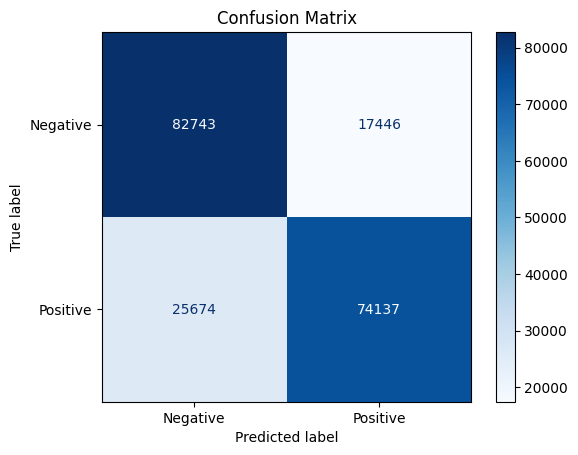

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.76      0.83      0.79    100189
    Positive       0.81      0.74      0.77     99811

    accuracy                           0.78    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.79      0.78      0.78    200000



In [ ]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_bow, train_labels)

predictions = tri_nb.predict(tri_test_bow)
tw_nb_tri_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])


##### 4.1.3.2 TFIDF

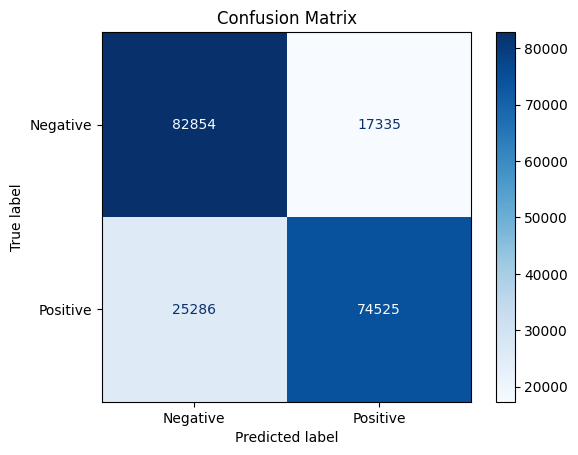

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.77      0.83      0.80    100189
    Positive       0.81      0.75      0.78     99811

    accuracy                           0.79    200000
   macro avg       0.79      0.79      0.79    200000
weighted avg       0.79      0.79      0.79    200000



In [ ]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_tfidf, train_labels)

predictions = tri_nb.predict(tri_test_tfidf)
tw_nb_tri_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

### 4.2 Logistische Regression

#### 4.2.1. Log Regression: Unigram

##### 4.2.1.1 Bag-of-Words

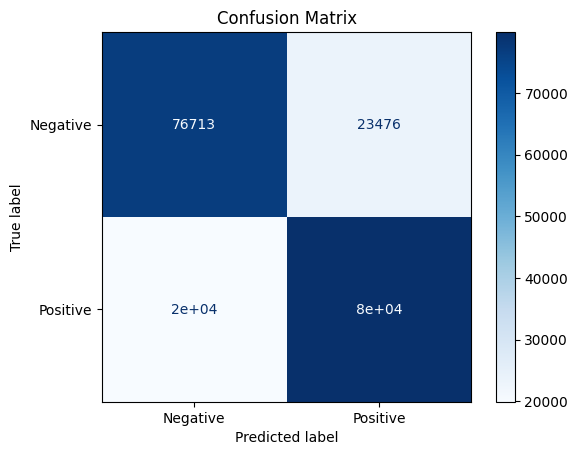

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    100189
    Positive       0.77      0.80      0.79     99811

    accuracy                           0.78    200000
   macro avg       0.78      0.78      0.78    200000
weighted avg       0.78      0.78      0.78    200000



In [ ]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_bow, train_labels)

predictions = uni_logreg.predict(uni_test_bow)
tw_lr_uni_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.2.1.2 TFIDF

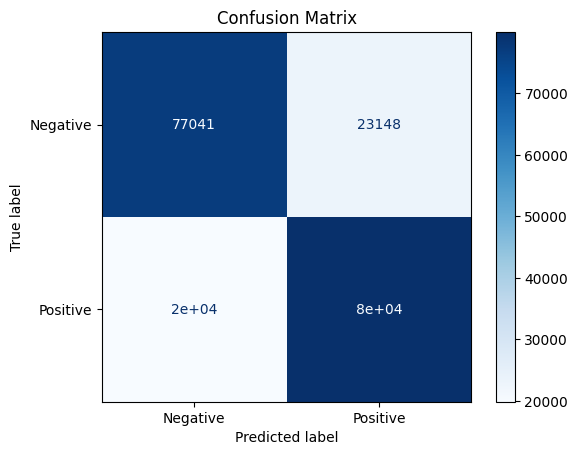

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    100189
    Positive       0.78      0.80      0.79     99811

    accuracy                           0.78    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.79      0.78      0.78    200000



In [ ]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_tfidf, train_labels)

predictions = uni_logreg.predict(uni_test_tfidf)
tw_lr_uni_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.2.2. Log Regression: Bigram

##### 4.2.2.1 Bag-of-Words

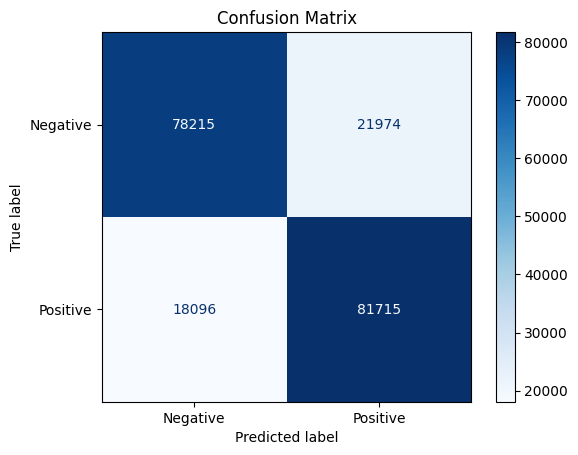

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.81      0.78      0.80    100189
    Positive       0.79      0.82      0.80     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [ ]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_bow, train_labels)

predictions = bi_logreg.predict(bi_test_bow)
tw_lr_bi_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.2.2.2 TFIDF

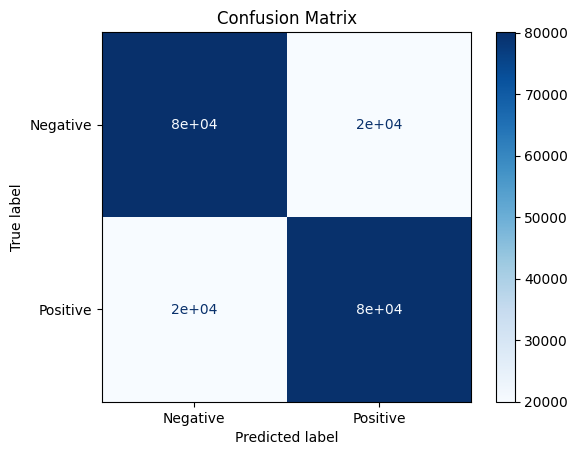

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80    100189
    Positive       0.80      0.80      0.80     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [ ]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_tfidf, train_labels)

predictions = bi_logreg.predict(bi_test_tfidf)
tw_lr_bi_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.2.3. Log Regression: Trigram

##### 4.2.3.1 Bag-of-Words

In [ ]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_bow, train_labels)

predictions = tri_logreg.predict(tri_test_bow)
tw_lr_tri_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.2.3.2 TFIDF

In [ ]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_tfidf, train_labels)

predictions = tri_logreg.predict(tri_test_tfidf)
tw_lr_tri_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

### 4.3 Linear Support Vector Machine (LSVM)

#### 4.3.1. LSVM: Unigram

##### 4.3.1.1 Bag-of-Words

In [ ]:
uni_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
uni_lsvm.fit(uni_train_bow, train_labels)

predictions = uni_lsvm.predict(uni_test_bow)
tw_ls_uni_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.3.1.2 TFIDF

In [ ]:
uni_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
uni_lsvm.fit(uni_train_tfidf, train_labels)

predictions = uni_lsvm.predict(uni_test_tfidf)
tw_ls_uni_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.3.2. LSVM: Bigram

##### 4.3.2.1 Bag-of-Words

In [ ]:
bi_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
bi_lsvm.fit(bi_train_bow, train_labels)

predictions = bi_lsvm.predict(bi_test_bow)
tw_ls_bi_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.3.2.2 TFIDF

In [ ]:
bi_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
bi_lsvm.fit(bi_train_tfidf, train_labels)

predictions = bi_lsvm.predict(bi_test_tfidf)
tw_ls_bi_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.3.3. LSVM: Trigram

##### 4.3.3.1 Bag-of-Words

In [ ]:
tri_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
tri_lsvm.fit(tri_train_bow, train_labels)

predictions = tri_lsvm.predict(tri_test_bow)
tw_ls_tri_bow = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.3.3.2 TFIDF

In [ ]:
tri_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
tri_lsvm.fit(tri_train_tfidf, train_labels)

predictions = tri_lsvm.predict(tri_test_tfidf)
tw_ls_tri_tf = test_statistics(predictions, test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

### 5.1. Bag-of-Words Ergebnisse

In [ ]:
tw_bow = {'Naive Bayes': [tw_nb_uni_bow, tw_nb_bi_bow, tw_nb_tri_bow], 'Log Regression': [tw_lr_uni_bow, tw_lr_bi_bow, tw_lr_tri_bow], 'LSVM': [tw_ls_uni_bow, tw_ls_bi_bow, tw_ls_tri_bow]}
df_tw_bow = pd.DataFrame((tw_bow), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_tw_bow)

### 5.2. TFIDF Ergebnisse

In [ ]:
(tw_tfidf) = {'Naive Bayes': [tw_nb_uni_tf, tw_nb_bi_tf, tw_nb_tri_tf], 'Log Regression': [tw_lr_uni_tf, tw_lr_bi_tf, tw_lr_tri_tf], 'LSVM': [tw_ls_uni_tf, tw_ls_bi_tf, tw_ls_tri_tf]}
df_tw_tfidf = pd.DataFrame((tw_tfidf), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_tw_tfidf)

Quellen:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://scikit-learn.org/stable/modules/naive_bayes.html
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://dropsofai.com/sentiment-analysis-with-python-bag-of-words/
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

